In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import sklearn

print('numpy==' + np.__version__)
print('pandas==' + pd.__version__)
print('matplotlib==' + matplotlib.__version__)
print('tensorflow-macos==' + tf.__version__)
print('sklearn==' + sklearn.__version__)

numpy==1.21.6
pandas==1.3.5
matplotlib==3.2.2
tensorflow-macos==2.8.2
sklearn==1.0.2


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = '1_qFAZgb0-6QOQdyt-qinU4lzkN5iSWv7'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data.csv')  

data_path = '/content/data.csv'
# data = pd.read_csv(data_path).drop(['Unnamed: 0', 'timestamp', 'negatives', 'neutrals', 'positives'], axis=1)
data = pd.read_csv(data_path).drop(['Unnamed: 0', 'timestamp'], axis=1)

data.head()
data_features = data.drop(['closing price on the next timestamp'], axis=1)
data_labels = data['closing price on the next timestamp']


In [ ]:
data = data.to_numpy()
print(data[:, :6].shape)
print(data[:,6].shape)

(26280, 6)
(26280,)


In [ ]:
# scaler = MinMaxScaler()
scaler = MinMaxScaler()
data = scaler.fit_transform(data)


train_size = int(0.8 * len(data))

def split_data(data_in):
    delay = 15
    feature, label = [], []

    for i in range(len(data_in) - delay):
        feature.append(data_in[:,:6][i: i + delay])
        label.append(data_in[i + delay-1, -1])
        
    return np.array(feature), np.array(label)

X_train, y_train = split_data(data[:train_size])
X_train, y_train = X_train[:-4], y_train[:-4]

X_test, y_test = split_data(data[train_size:])
X_test, y_test = X_test[:-4], y_test[:-4]

print(X_train.shape)

(21005, 15, 6)


In [ ]:
# split train X data into 5 datasets
newarr = np.array_split(X_train, 5)
X_train_1 = newarr[0] 
X_train_2 = newarr[1]
X_train_3 = newarr[2]
X_train_4 = newarr[3]
X_train_5 = newarr[4]
print(X_train_1.shape)
print(X_train_5.shape)

# split train y data into 5 datasets
newarr_y = np.array_split(y_train, 5)
y_train_1 = newarr_y[0] 
y_train_2 = newarr_y[1]
y_train_3 = newarr_y[2]
y_train_4 = newarr_y[3]
y_train_5 = newarr_y[4]
print(y_train_5.shape)

(4201, 15, 6)
(4201, 15, 6)
(4201,)


In [ ]:
# Train dataset 1 （1-4）
X_train_dataset_1 = X_train_1+X_train_2+X_train_3+X_train_4

# Train dataset 2 （1-3，5）
X_train_dataset_2 = X_train_1+X_train_2+X_train_3+X_train_5

# Train dataset 3 （1，2，4，5）
X_train_dataset_3 = X_train_1+X_train_2+X_train_4+X_train_5

# Train dataset 4 （1，3-5）
X_train_dataset_4 = X_train_1+X_train_3+X_train_4+X_train_5

# Train dataset 5 （2-5）
X_train_dataset_5 = X_train_2+X_train_3+X_train_4+X_train_5

print(X_train_dataset_5.shape)

(4201, 15, 6)


In [ ]:
# Test dataset 1 （1-4）
y_train_dataset_1 = y_train_1+y_train_2+y_train_3+y_train_4

# Test dataset 2 （1-3，5）
y_train_dataset_2 = y_train_1+y_train_2+y_train_3+y_train_5

# Test dataset 3 （1，2，4，5）
y_train_dataset_3 = y_train_1+y_train_2+y_train_4+y_train_5

# Test dataset 4 （1，3-5）
y_train_dataset_4 = y_train_1+y_train_3+y_train_4+y_train_5

# Test dataset 5 （2-5）
y_train_dataset_5 = y_train_2+y_train_3+y_train_4+y_train_5

print(y_train_dataset_5.shape)

(4201,)


In [ ]:
models = [
    keras.Sequential([
        layers.GRU(128),
        layers.Dense(1)
    ]) for i in range(5)
]

In [ ]:
X_train_datasets = [X_train_dataset_1,X_train_dataset_2,X_train_dataset_3,X_train_dataset_4,X_train_dataset_5]
y_train_datasets = [y_train_dataset_1,y_train_dataset_2,y_train_dataset_3,y_train_dataset_4,y_train_dataset_5]

for model, X_train, y_train in zip(models, X_train_datasets, y_train_datasets):
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.0003))
    history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/50
33/33 [==============================] - 3s 37ms/step - loss: 0.3321 - val_loss: 0.0321
Epoch 2/50
33/33 [==============================] - 1s 27ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 3/50
33/33 [==============================] - 1s 27ms/step - loss: 0.0019 - val_loss: 0.0080
Epoch 4/50
33/33 [==============================] - 1s 27ms/step - loss: 0.0017 - val_loss: 0.0081
Epoch 5/50
33/33 [==============================] - 1s 27ms/step - loss: 0.0015 - val_loss: 0.0075
Epoch 6/50
33/33 [==============================] - 1s 27ms/step - loss: 0.0014 - val_loss: 0.0068
Epoch 7/50
33/33 [==============================] - 1s 27ms/step - loss: 0.0013 - val_loss: 0.0064
Epoch 8/50
33/33 [==============================] - 1s 27ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 9/50
33/33 [==============================] - 1s 27ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 10/50
33/33 [==============================] - 1s 27ms/step - loss: 9.5164e-04 - val_loss: 0.0049
Epoch

In [ ]:
# plt.figure(figsize=(16, 10))
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Test Loss')
# plt.legend()
# plt.title('Train and Test RMSE')
# plt.show()

In [ ]:
predictions = []
for model in models:
    predictions.append(model.predict(X_test))

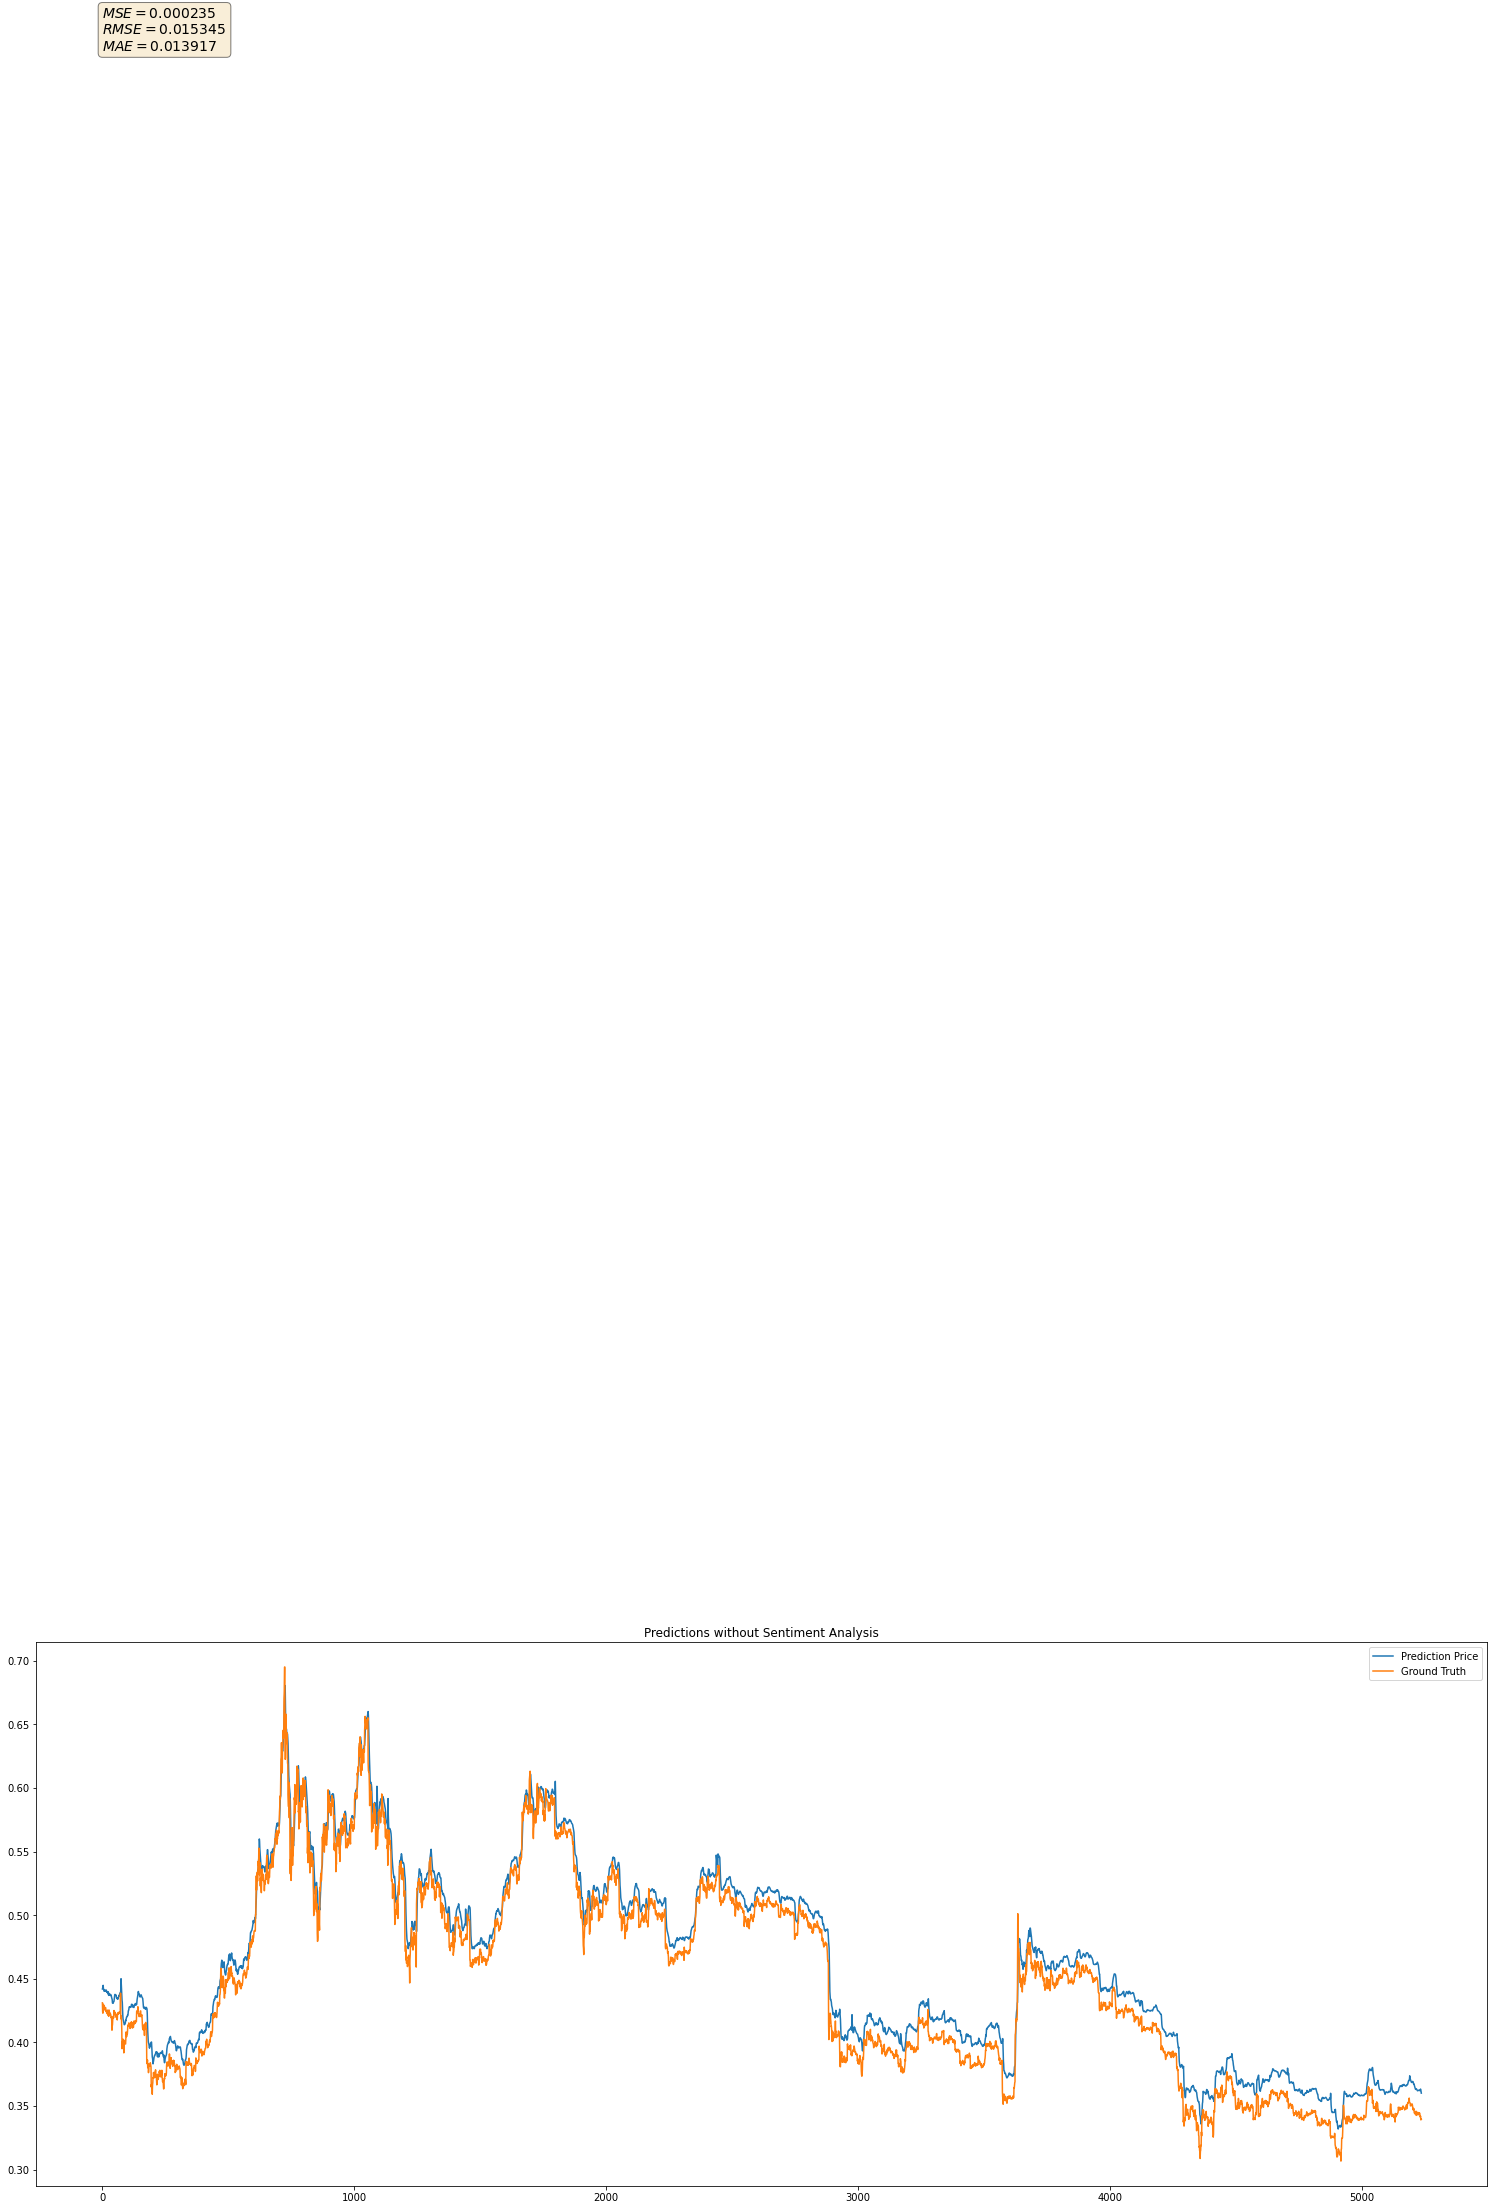

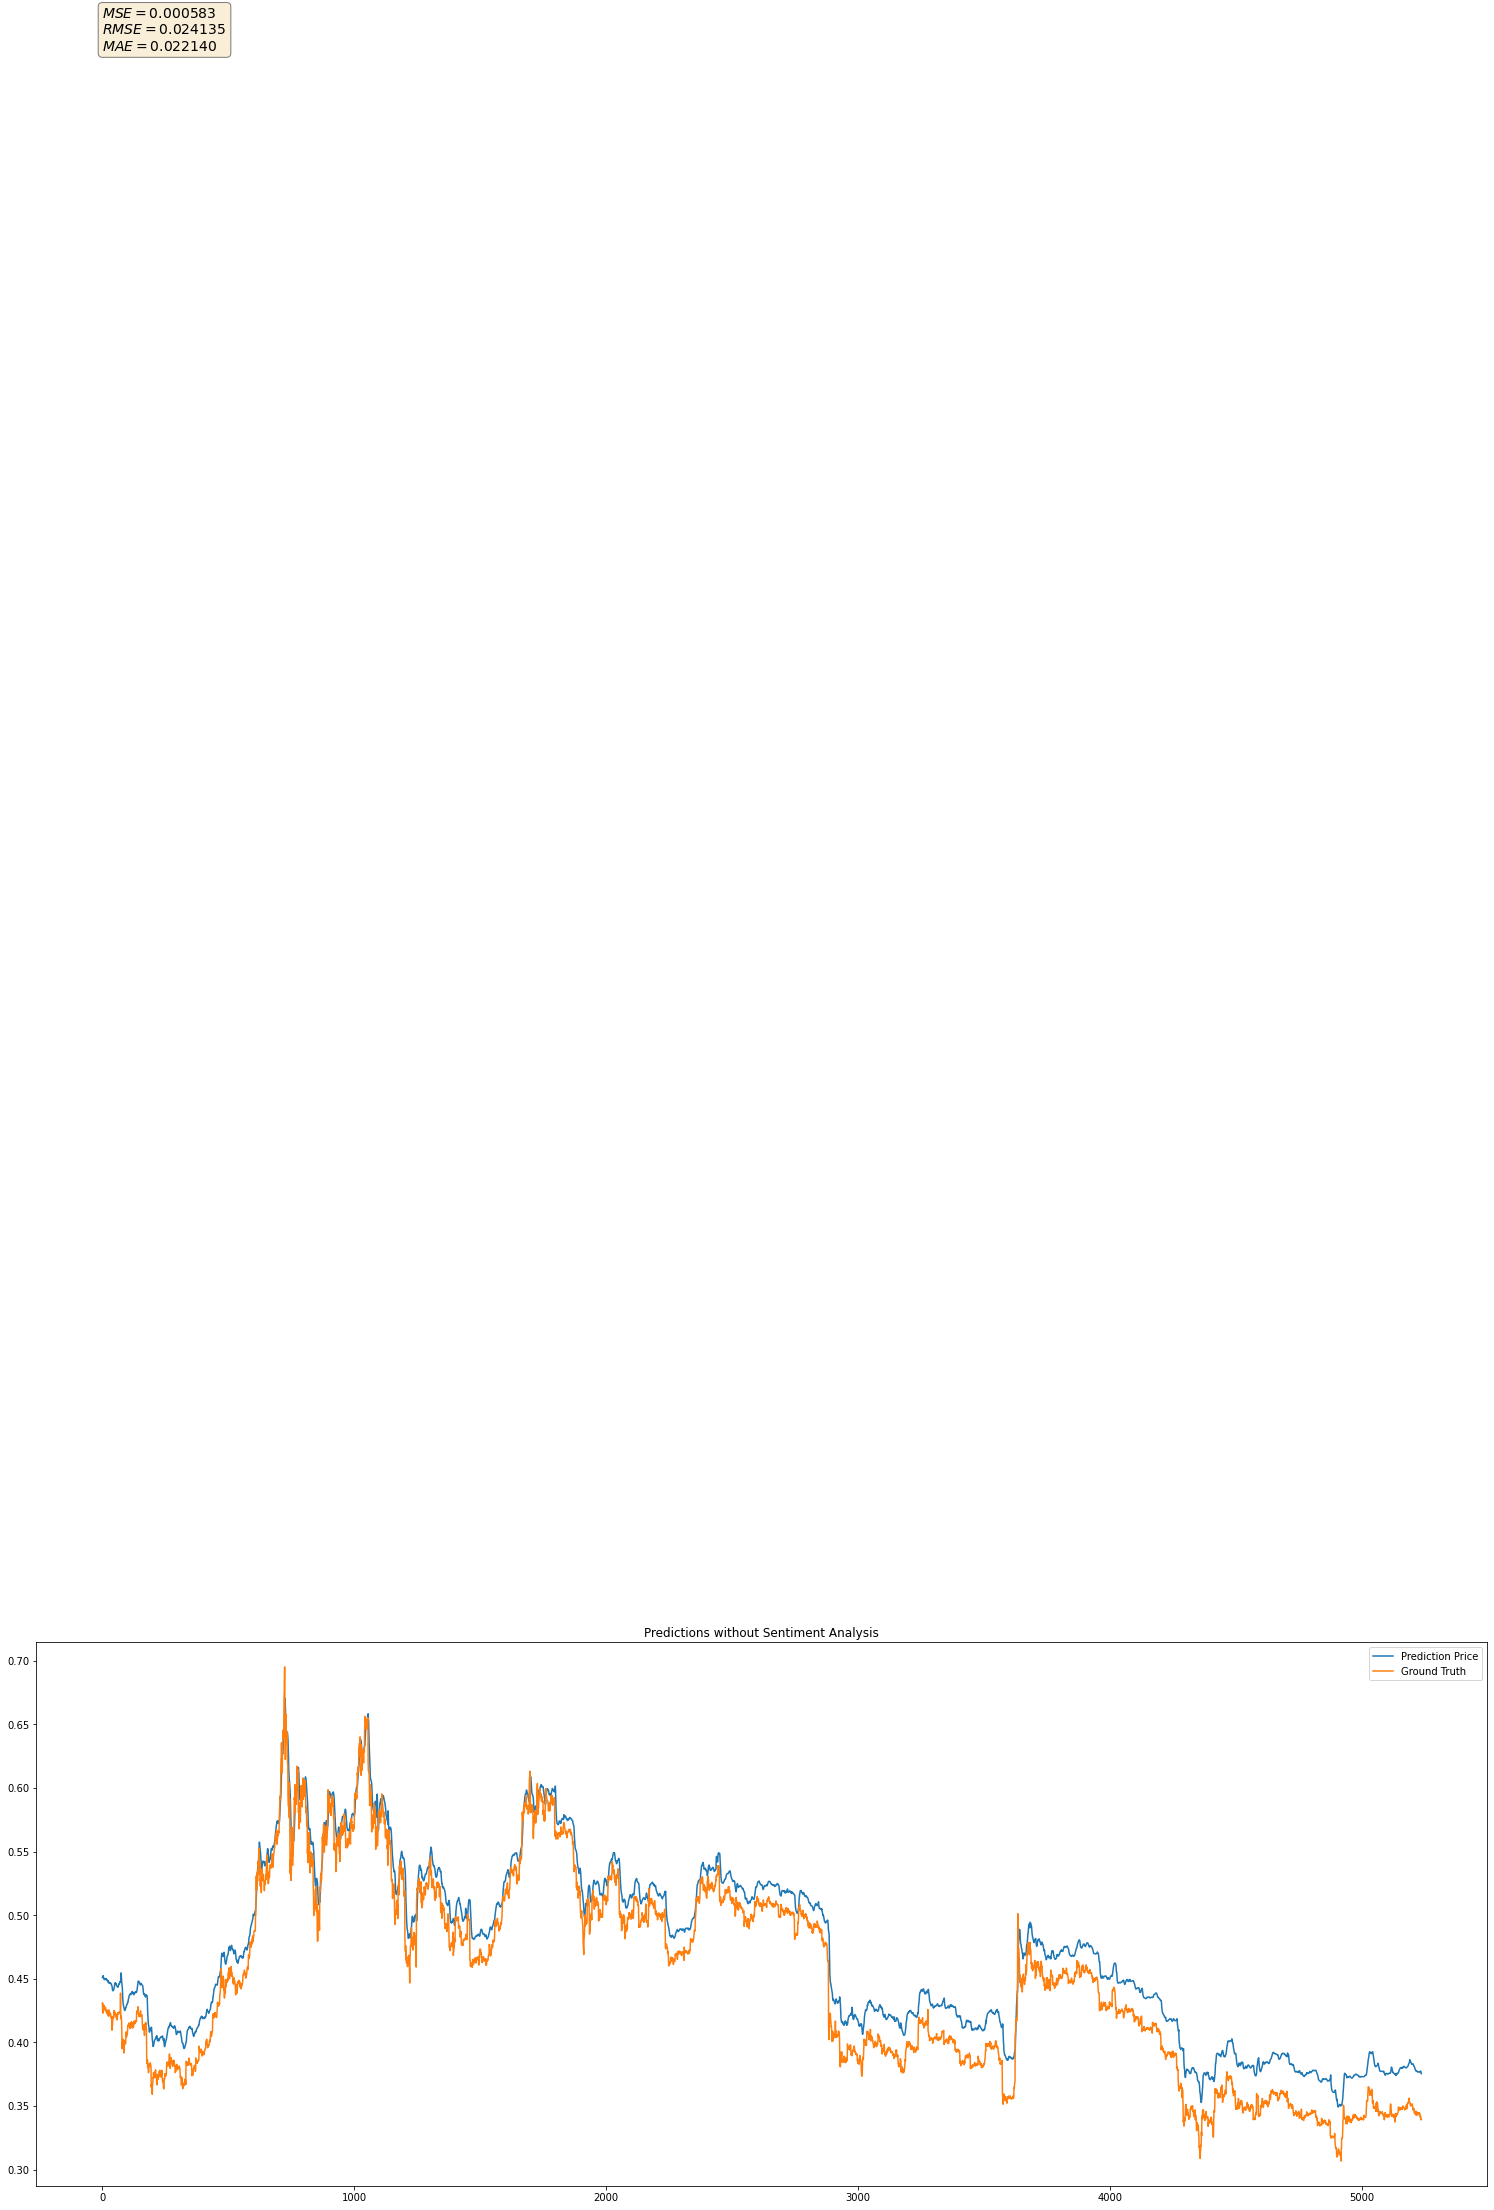

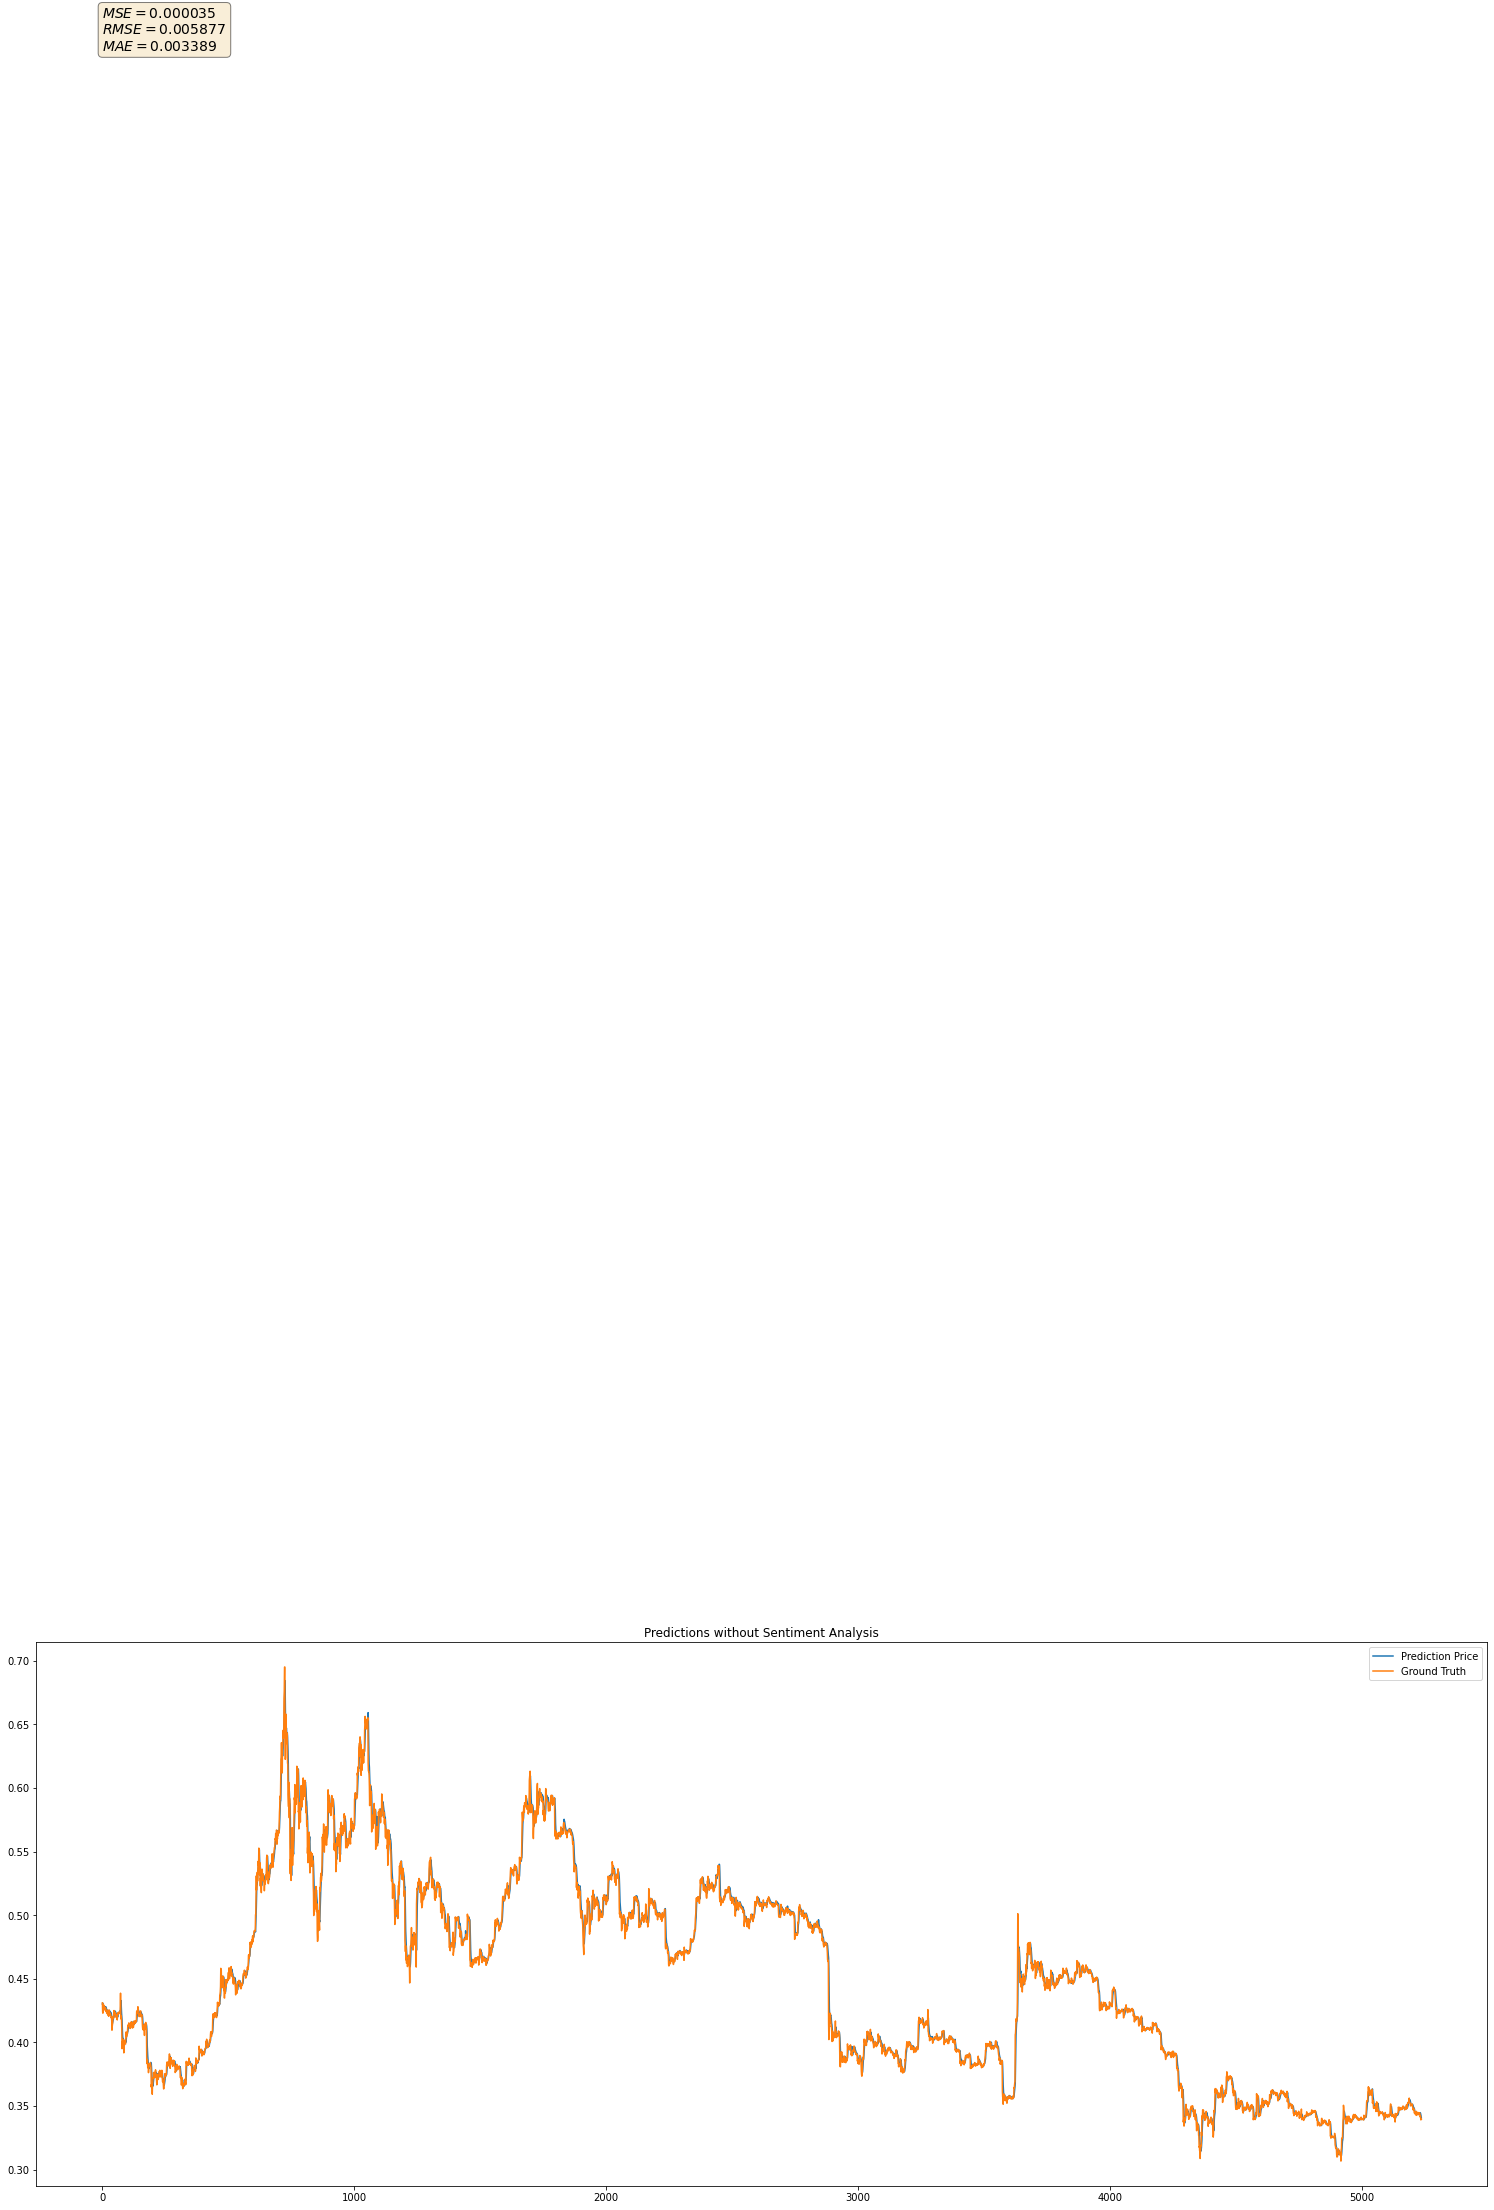

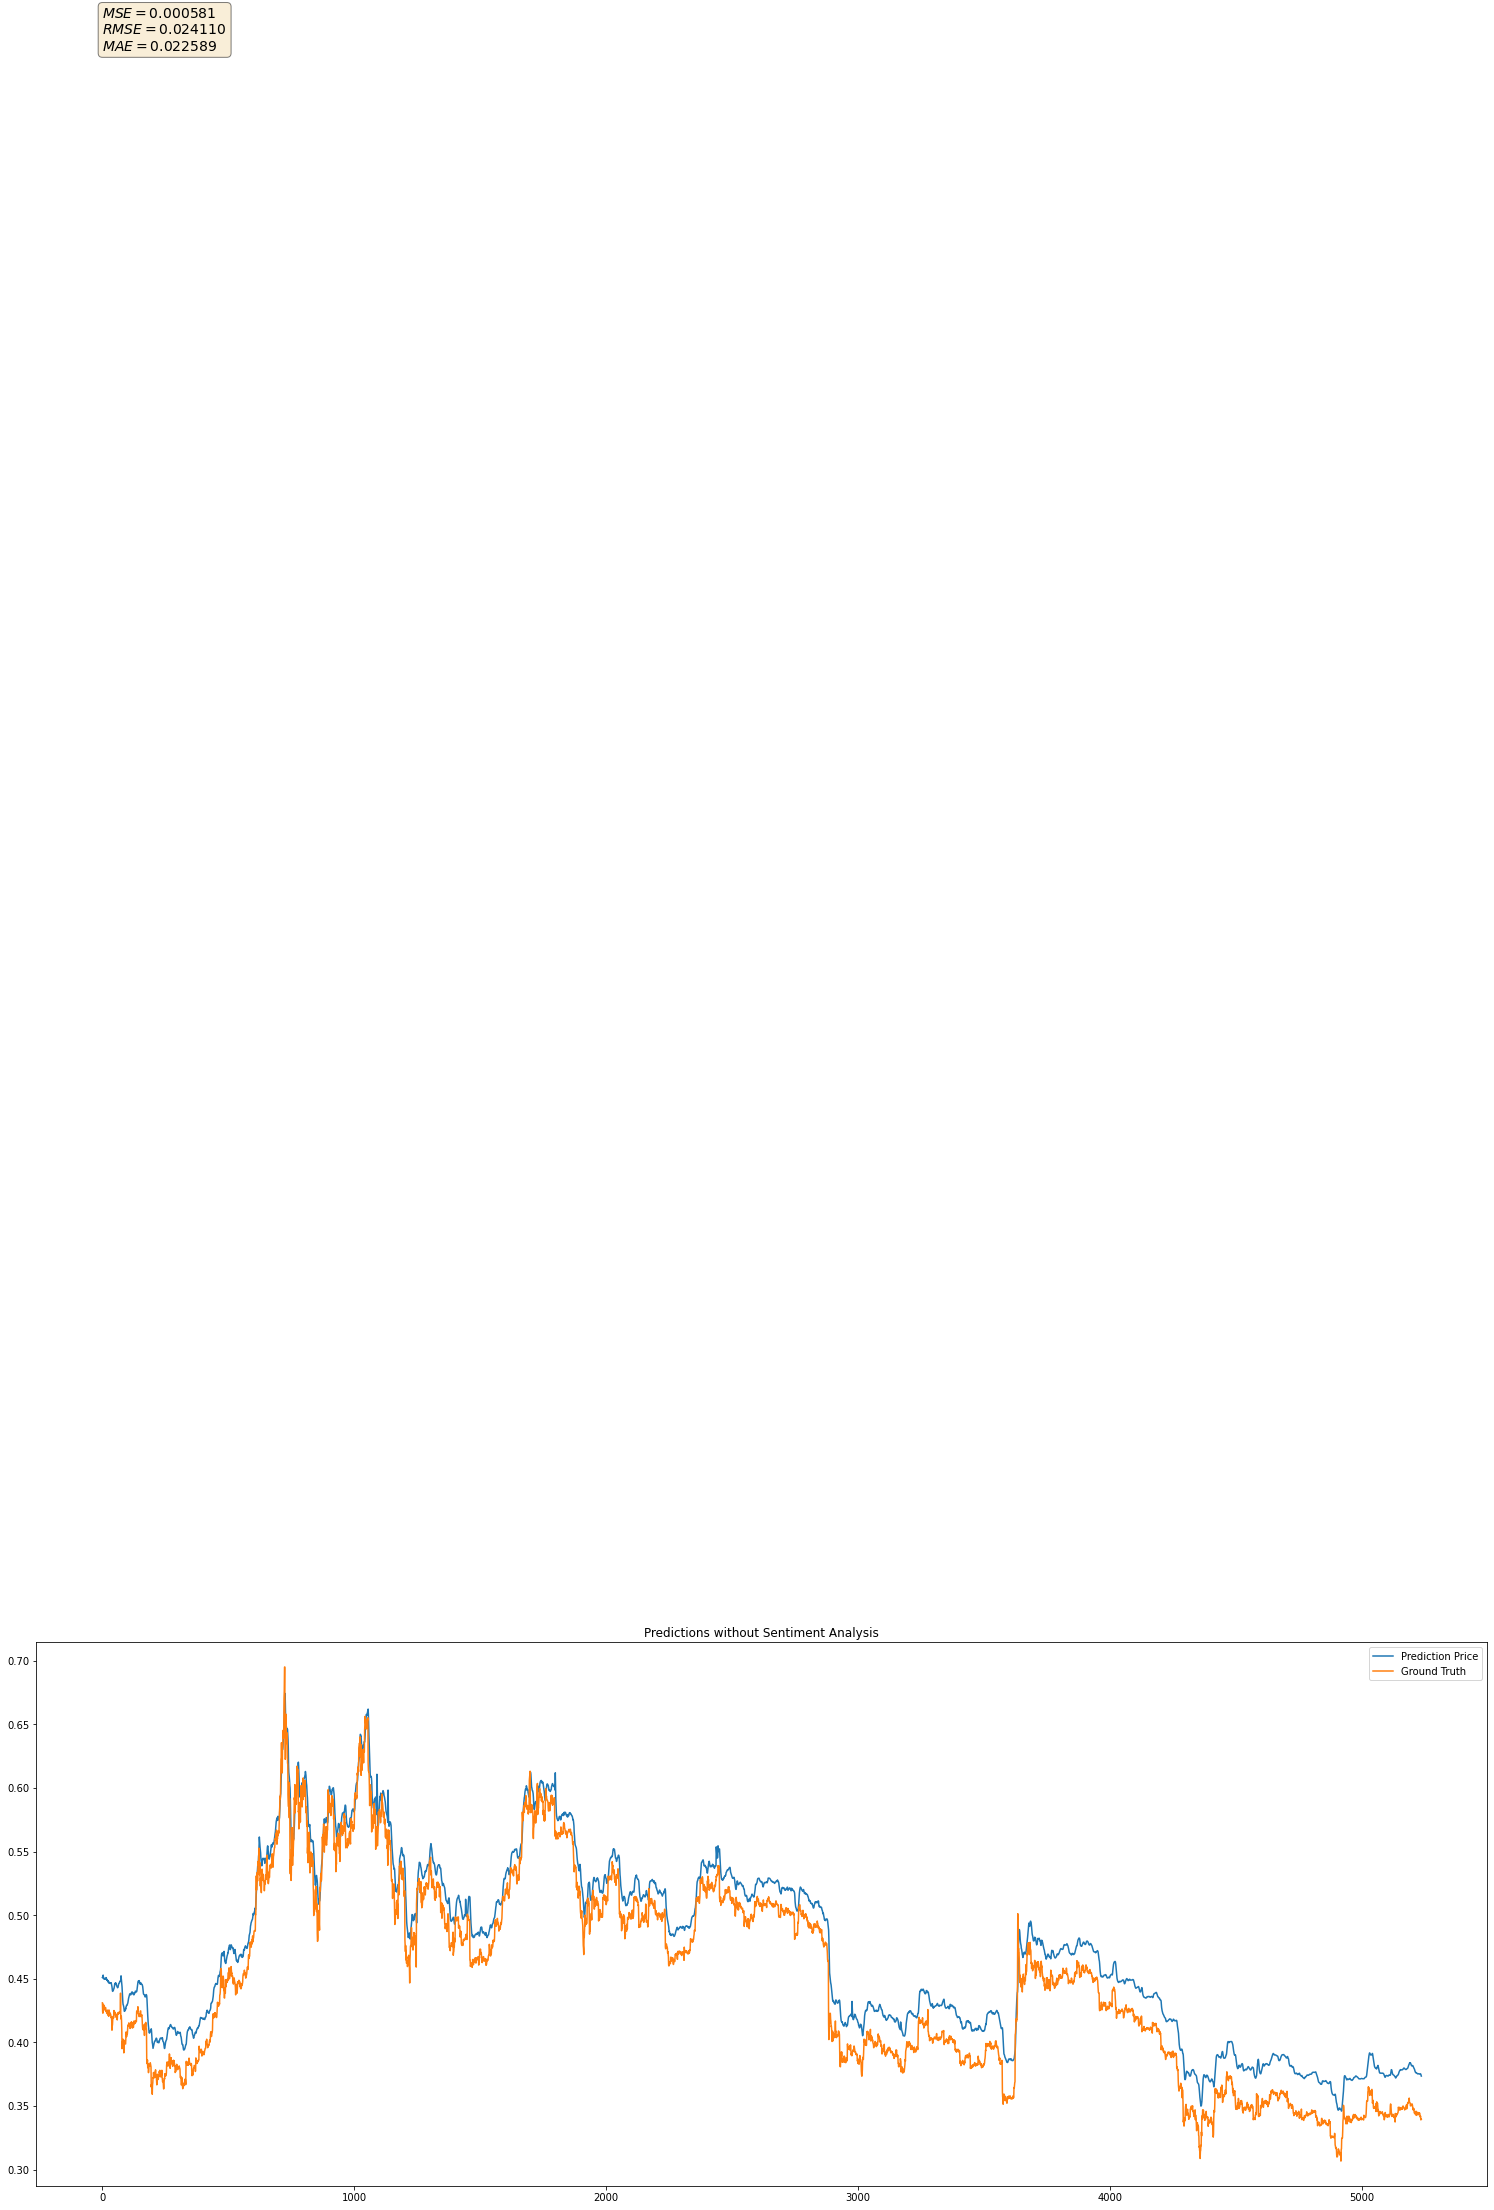

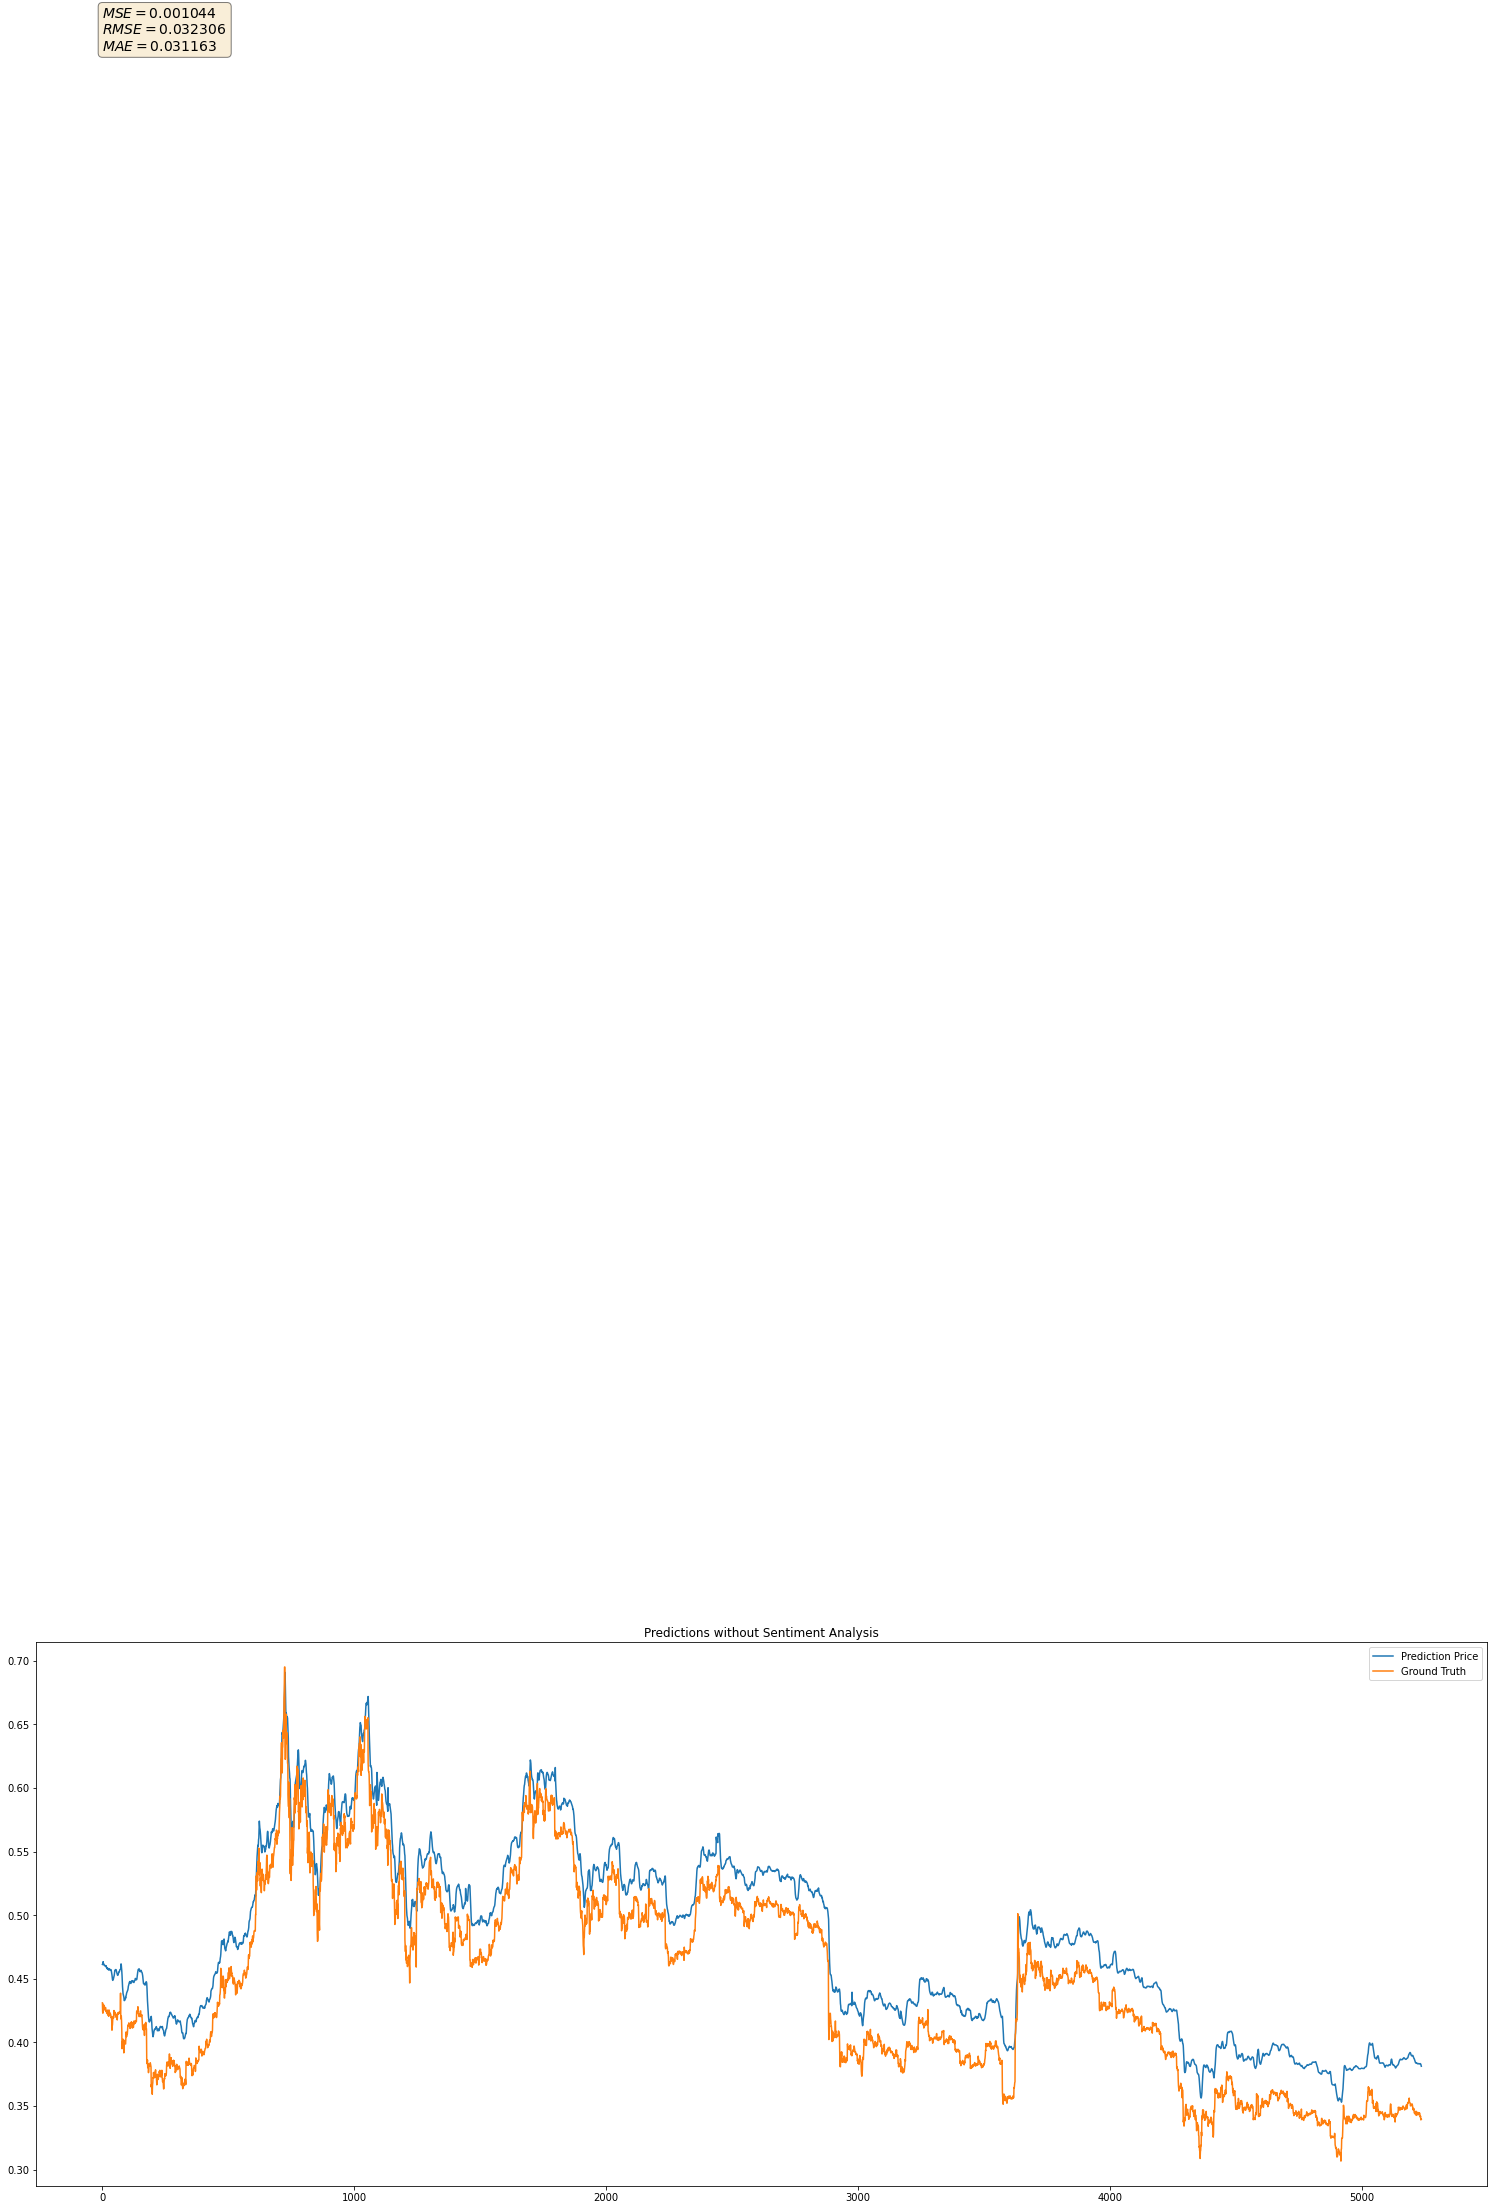

In [ ]:
# prediction = model.predict(X_test)
for prediction in predictions:
    mse = mean_squared_error(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mae = mean_absolute_error(y_test, prediction)

    metrics = '\n'.join((
        '$MSE=%f$' % (mse),
        '$RMSE=%f$' % (rmse),
        '$MAE=%f$' % (mae)
    ))

    plt.figure(figsize=(26, 10))
    # plt.plot(scaler.inverse_transform(prediction), label='Prediction Price')
    # plt.plot(scaler.inverse_transform(y_test), label='Ground Truth')
    plt.plot(prediction, label='Prediction Price')
    plt.plot(y_test, label='Ground Truth')
    plt.legend()
    plt.title('Predictions without Sentiment Analysis')

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0, 2, metrics, fontsize=14,
            verticalalignment='top', bbox=props)

    # plt.savefig('no_senti.png', dpi=500)
    plt.show()

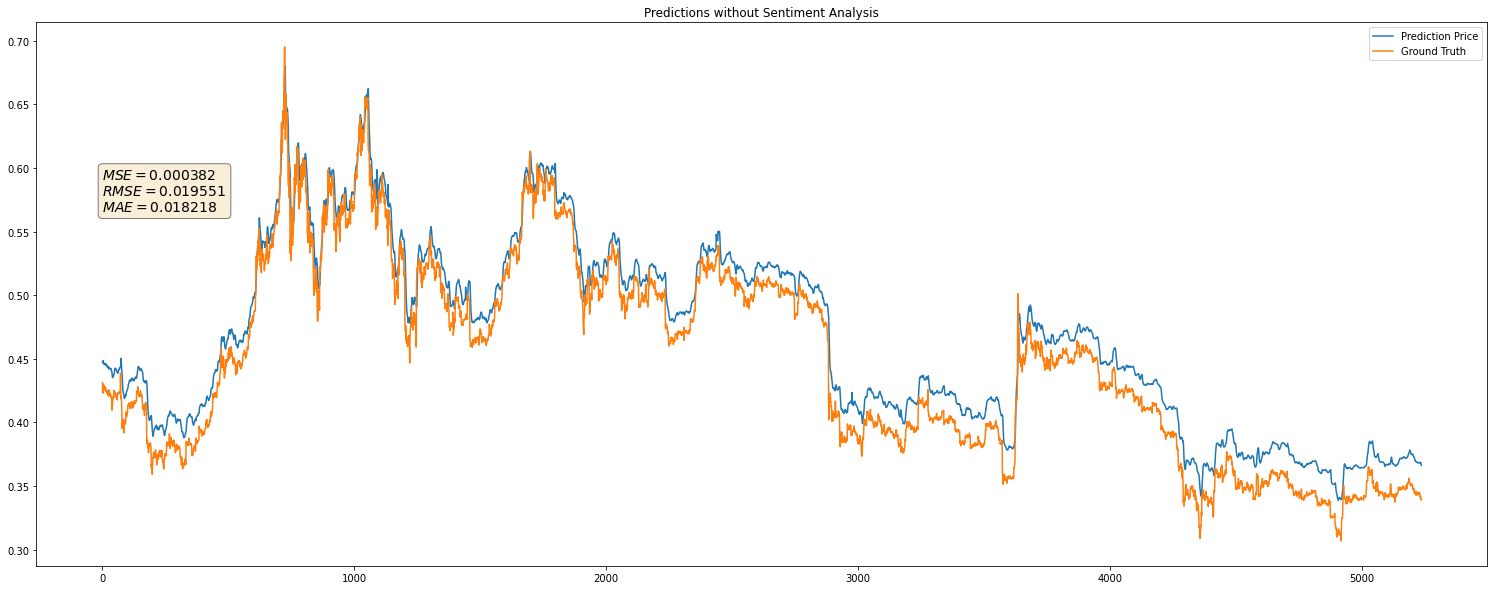

In [ ]:
prediction = np.mean(np.array(predictions), axis=0)
mse = mean_squared_error(y_test, prediction)
rmse = mean_squared_error(y_test, prediction, squared=False)
mae = mean_absolute_error(y_test, prediction)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
# plt.plot(scaler.inverse_transform(prediction), label='Prediction Price')
# plt.plot(scaler.inverse_transform(y_test), label='Ground Truth')
plt.plot(prediction, label='Prediction Price')
plt.plot(y_test, label='Ground Truth')
plt.legend()
plt.title('Predictions without Sentiment Analysis')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 0.6, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()